In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d
from data_generation import generate_ode_data

collocation_path = os.path.abspath(os.path.join('..', '04_energy_consumption_reformat'))

if collocation_path not in sys.path:
    sys.path.append(collocation_path)
    
import nn_pyomo
import importlib
import preprocessing

In [30]:
importlib.reload(preprocessing)
from preprocessing import load_data, preprocess_data 

reload_data = False

if reload_data:
        file_path = '../04_energy_consumption_reformat/df_train.csv'
        start_date_1 = '2015-01-10'
        start_date_2 = '2016-01-10'
        number_of_points = 350

        # sigma = 1, split = 300, num_nodes_mult = 1, equally_spaced = False
        data_subsample = load_data(file_path, start_date_1, number_of_points)
        df_train_1, df_test_1 = preprocess_data(data_subsample, 48, 2, sigma = 0.05)
        data_subsample = load_data(file_path, start_date_2, number_of_points)
        df_train_2, df_test_2 = preprocess_data(data_subsample, 48, 2, sigma = 0.05)

        # shift the time
        shift = max(df_train_2['t']) - min(df_train_2['t'])
        df_train_2['t'] = df_train_2['t'] + shift
        df_test_2['t'] = df_test_2['t'] + shift

        # prepare data
        ys = np.concatenate([np.atleast_2d(df_train_1['y']), np.atleast_2d(df_train_2['y'])], axis = 1).T
        ts = np.concatenate([df_train_1['t'], df_train_2['t']])
        Xs = np.concatenate([np.atleast_2d(df_train_1.drop(columns=['y', 't'])).T, np.atleast_2d(df_train_2.drop(columns=['y', 't'])).T], axis = 1).T

        weights_1 = compute_weights(df_train_1['t'])
        D_1 = np.array(lagrange_derivative(df_train_1['t'], weights_1))
        weights_2 = compute_weights(df_train_2['t'])
        D_2 = np.array(lagrange_derivative(df_train_2['t'], weights_2))

        Ds = [D_1, D_2]

# solve
import nn_pyomo_admm
importlib.reload(nn_pyomo_admm)
NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

tol = 1e-8
params = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 500}

layer_sizes = [5, 20, 1]

ode_model = NeuralODEPyomoADMM(y_observed = ys, 
                        t = ts, # t
                        first_derivative_matrix = Ds, # derivative matrix
                        extra_input = Xs, # extra inputs
                        y_init = ys,
                        layer_sizes = layer_sizes, act_func = "tanh", 
                        penalty_lambda_reg = 0.01, 
                        rho = 1.0,
                        time_invariant = True,
                        w_init_method = 'xavier', 
                        params = params
                        )

ode_model.build_model()
result = ode_model.admm_solve(iterations=10, tol_primal=1e-1)

The first/ last time points in the subsample are 2015-01-10 00:00:00/ 2015-01-17 06:30:00
Covering 7 days
Number of points per day: 48
Time offset needed for 1 day: 0.13714285714285715
Training data: 204 timepoints
Training data: 50 timepoints
Training data: 204 timepoints after interpolation
The first/ last time points in the subsample are 2016-01-10 00:00:00/ 2016-01-17 06:30:00
Covering 7 days
Number of points per day: 48
Time offset needed for 1 day: 0.13714285714285715
Training data: 204 timepoints
Training data: 50 timepoints
Training data: 204 timepoints after interpolation
----------------------------------------------------------------------------------------------------
ADMM Iteration 1/10; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-08
compl_inf_tol=1e-08
constr_viol_tol=1e-08
halt_on_ampl_error=yes
print_level=5
max_iter=500


*************************************************

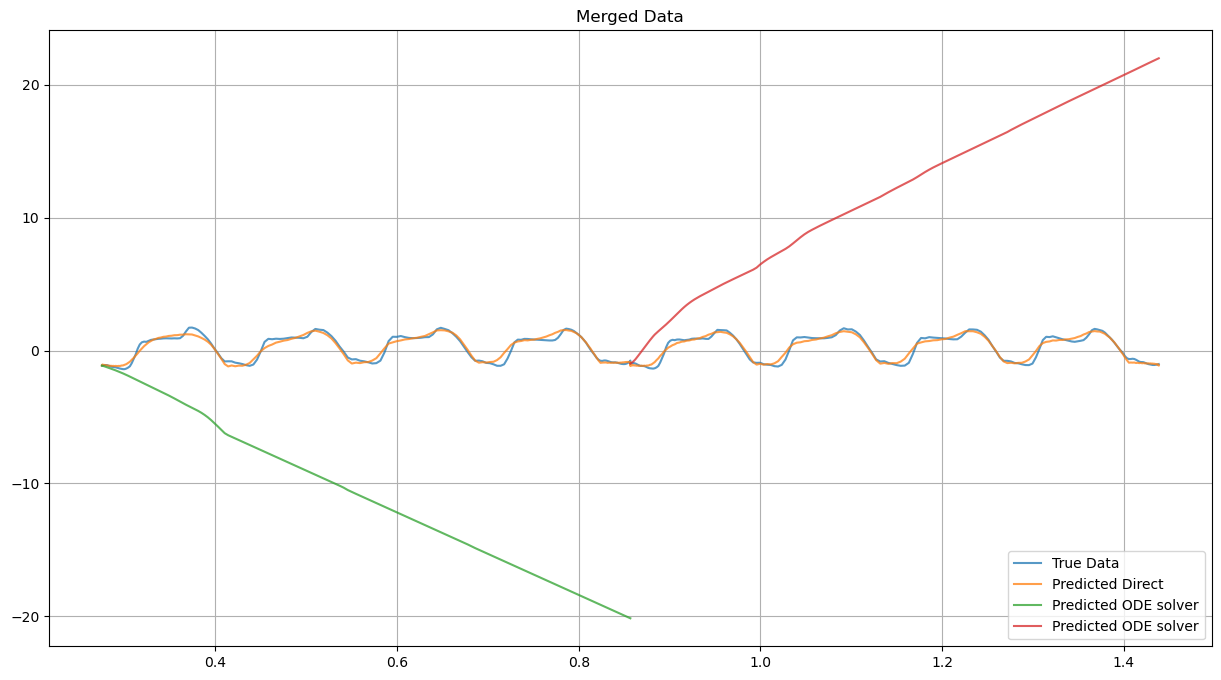

In [14]:
importlib.reload(nn_pyomo_admm)
ode_model.neural_ode = nn_pyomo_admm.NeuralODEPyomoADMM.neural_ode.__get__(ode_model)
M = len(ts)//2
u_model = ode_model.extract_solution().T
y0 = ys[0]
y_pred1 = ode_model.neural_ode(y0, ts[:M], (Xs[:M], ts[:M]), 'consensus')
y0 = ys[M]
y_pred2 = ode_model.neural_ode(y0, ts[M:], (Xs[M:], ts[M:]), 'consensus')
plt.figure(figsize=(15, 8))
plt.plot(ts, ys, label='True Data', alpha = 0.75)
plt.plot(ts, u_model, label='Predicted Direct', alpha = 0.75)
plt.plot(ts[:M], y_pred1, label='Predicted ODE solver', alpha = 0.75)
plt.plot(ts[M:], y_pred2, label='Predicted ODE solver', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

In [25]:
trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-5
params = {"tol":1e-8, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 100 }

initial_state = (ys[:M][0])
direct_solver = DirectODESolver(np.array(ts[:M]), layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs[:M]))

direct_solver.build_model()
solver_info = direct_solver.solve_model()
t_solution_1, y_solution_1 = direct_solver.extract_solution()

initial_state = (ys[M:][0])
direct_solver = DirectODESolver(np.array(ts[M:]), layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs[M:]))

direct_solver.build_model()
solver_info = direct_solver.solve_model()
t_solution_2, y_solution_2 = direct_solver.extract_solution()

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     1017
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      204

Total number of variables............................:      408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      407
Total number

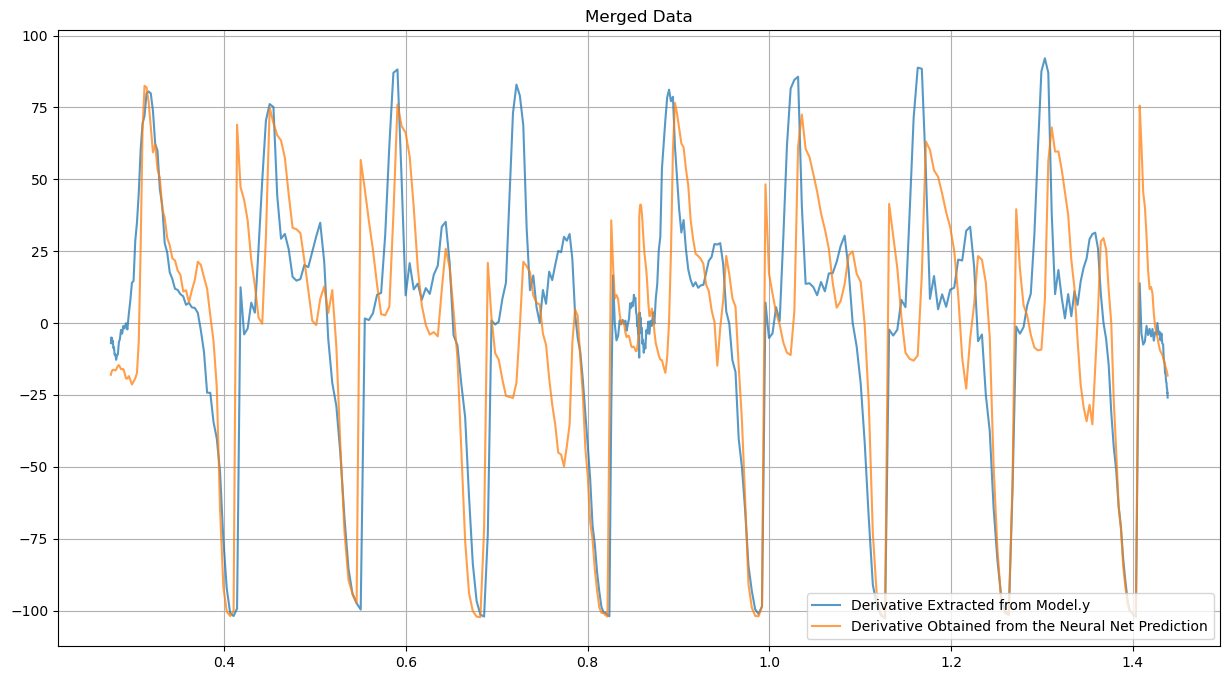

In [29]:
model_derivative = ode_model.extract_derivative()
combined_derivative = np.concatenate([model_derivative[0][1:], model_derivative[1][1:]])

df_train = pd.concat([df_train_1, df_train_2])
df_train.sort_values('t', inplace=True)
df_train = df_train.drop(columns='t')
df_train.reset_index(drop=True, inplace=True)

# arrange columns in the expected order
temp_column = df_train['y']
df_train = df_train.drop(['y'], axis=1)
df_train.insert(loc=0, column='y', value=temp_column)

derivative = []
for index in range(len(df_train)):
    derivative.append(ode_model.predict(jnp.array(df_train.loc[index]), weights = 'consensus'))

d1 = [d.item() for d in derivative]

plt.figure(figsize=(15, 8))
plt.plot(ts[2:], combined_derivative, label='Derivative Extracted from Model.y',alpha = 0.75)
plt.plot(ts, d1, label='Derivative Obtained from the Neural Net Prediction',alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

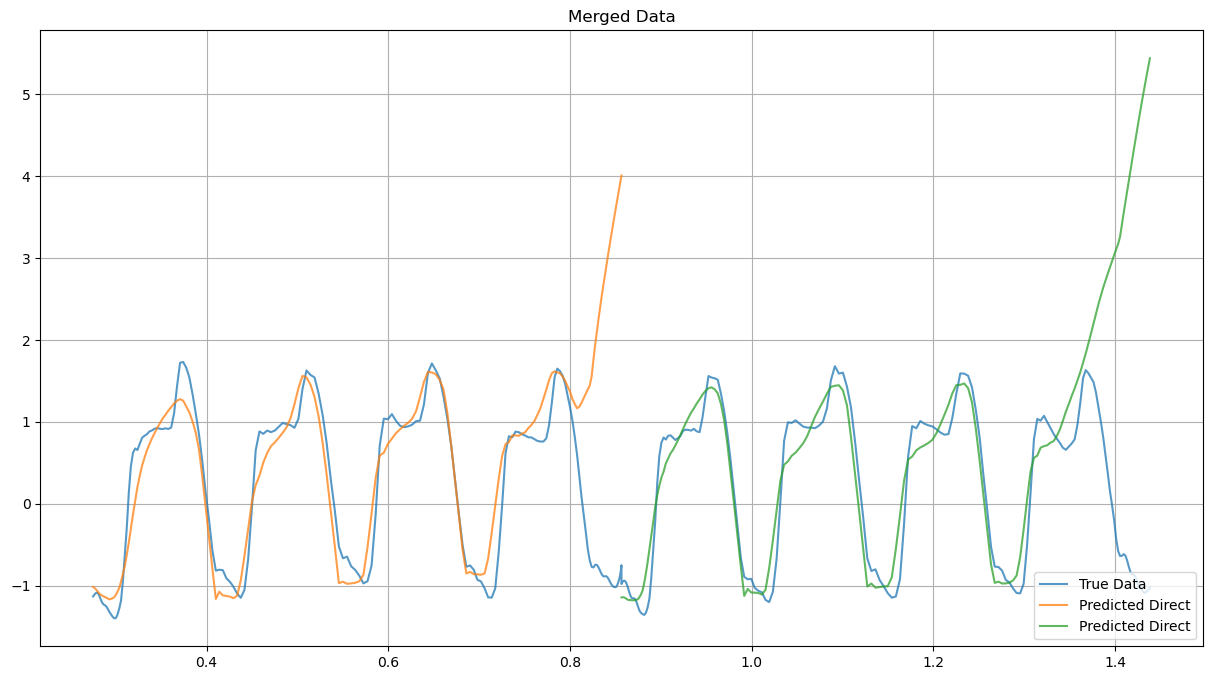

In [27]:
plt.figure(figsize=(15, 8))
plt.plot(ts, ys, label='True Data', alpha = 0.75)
plt.plot(t_solution_1, y_solution_1, label='Predicted Direct', alpha = 0.75)
plt.plot(t_solution_2, y_solution_2, label='Predicted Direct', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

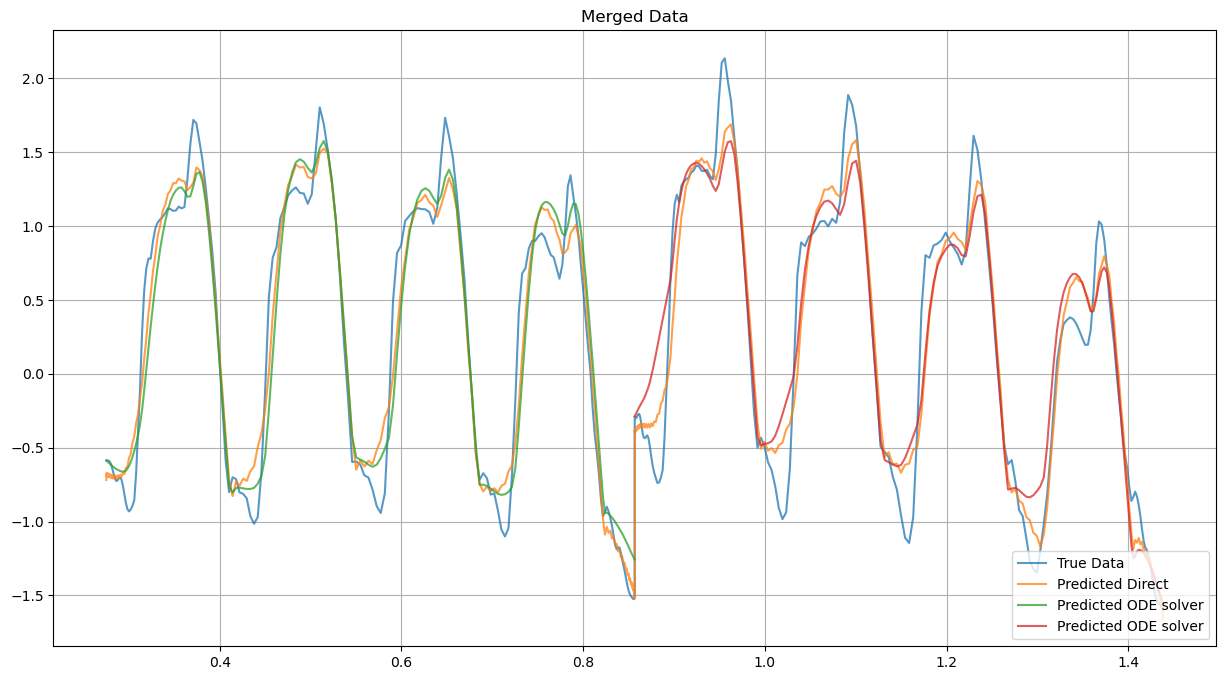

In [12]:
reload = False

if reload:
    start_date_1 = '2010-01-10'
    start_date_2 = '2011-01-10'
    importlib.reload(nn_pyomo_admm)
    ode_model.neural_ode = nn_pyomo_admm.NeuralODEPyomoADMM.neural_ode.__get__(ode_model)
    M = len(ts)//2
    u_model = ode_model.extract_solution().T
    y0 = ys[0]
    y_pred1 = ode_model.neural_ode(y0, ts[:M], (Xs[:M], ts[:M]), 'consensus')
    y0 = ys[M]
    y_pred2 = ode_model.neural_ode(y0, ts[M:], (Xs[M:], ts[M:]), 'consensus')
    plt.figure(figsize=(15, 8))
    plt.plot(ts, ys, label='True Data', alpha = 0.75)
    plt.plot(ts, u_model, label='Predicted Direct', alpha = 0.75)
    plt.plot(ts[:M], y_pred1, label='Predicted ODE solver', alpha = 0.75)
    plt.plot(ts[M:], y_pred2, label='Predicted ODE solver', alpha = 0.75)
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.title("Merged Data")
    plt.show()